In [3]:
cd.SkyCoord('23h23m25s+58d49m24s')

<SkyCoord (ICRS): (ra, dec) in deg
    (350.85416667, 58.82333333)>

In [3]:
hvig = fits.open('./share/sixte/instruments/hex-p/het/HEXP_HET_vign_sixte_v03.fits')
lvig = fits.open('./share/sixte/instruments/hex-p/let/HEXP_LET_vign_sixte_v03.fits')

In [4]:
hvig.info()

Filename: ./share/sixte/instruments/hex-p/het/HEXP_HET_vign_sixte_v03.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  VIGNETTING    1 BinTableHDU     48   1R x 5C   [5475E, 5475E, 8E, 43800E, E]   


In [6]:
hvig = tab(hvig[1].data)

In [7]:
lvig = tab(lvig[1].data)

In [16]:
hvig.columns

<TableColumns names=('ENERG_LO','ENERG_HI','THETA','VIGNET','PHI')>

In [20]:
hvig['THETA'][0]

array([0.        , 0.01666667, 0.03333334, 0.05      , 0.06666667,
       0.08333334, 0.1       , 0.11666667], dtype=float32)

In [15]:
heng = hvig['ENERG_LO']

In [22]:

from scipy.interpolate import griddata as gd

def get_vig(vigtab, energy, offaxis_arcmin, obsdate='2019-12-01', diagonal=True):
    """A function to find the vignetting function for a given detector at a given energy

    Input: 
    Mandatory:
    detname: detector name, e.g., 'T01'
    energy: energy array or scalar for vignetting calculations
    offaxis_arcmin: off-axis angle in arcmin for vignetting calculations
    Note -- energy and offaxis_arcmin should be of the same length.

    Optional:
    obsdate: see martxcfun.get_caldb_item for explanations. 
    version: version of the CALDB to be used. 
    diagonal: for energy and offaxis_arcmin arrays of length n, the default output is
    a 1-d array with length n. Setting diagonal=False will return a n by n matrix instead.


    Unit test: To be written

    # CTC: alternative algorithm is scipy.interpolate.interp2d,
    # which is ~40% faster but has an unavoidable RuntimeWarning 
    # replace anything under vig_emed with the following lines
    engrid, thgrid = np.meshgrid(vig_emed, vig_theta)
    vigfunc_2d = interp2d(engrid, thgrid, vignet, kind='linear')
    vigvalues = vigfunc_2d(energy, offaxis_arcmin)
    if diagonal:
        return vigvalues.diagonal()
    else:
        return vigvalues
    """
    vig_theta = vigtab['THETA'][0]*60
    if len(np.shape(vigtab['VIGNET'][0])) == 2:
        vignet = vigtab['VIGNET'][0]
    elif len(np.shape(vigtab['VIGNET'][0])) == 3:
        vignet = vigtab['VIGNET'][0][0]
    vig_elo = vigtab['ENERG_LO'][0]
    vig_ehi = vigtab['ENERG_HI'][0]
    vig_emed = (vig_elo + vig_ehi) / 2.


    grid_e, grid_th = np.meshgrid(energy, offaxis_arcmin)
    points = np.transpose(
        [np.tile(vig_emed, len(vig_theta)), \
         np.repeat(vig_theta, len(vig_emed))]
    )
    values = vignet.flatten()
    vigvalues = gd(points, values, (grid_e, grid_th), method='linear')
    if diagonal:
        return vigvalues.diagonal()
    else:
        return vigvalues


In [25]:
vigs = get_vig(hvig, np.zeros(10)+10,np.linspace(0.,7,10))

Text(0.5, 1.0, 'LET (2keV)')

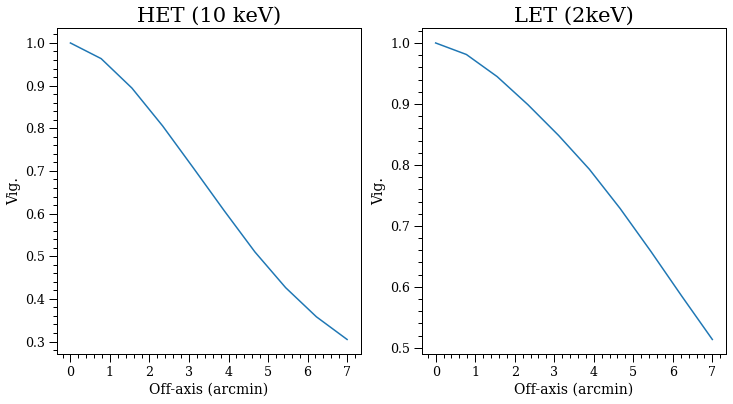

In [38]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(np.linspace(0.,7,10), vigs)
ax.set_xlabel('Off-axis (arcmin)')
ax.set_ylabel('Vig.')
ax.set_title('HET (10 keV)')

ax2 = fig.add_subplot(122)

ax2.plot(np.linspace(0.,7,10), vig_let)
ax2.set_xlabel('Off-axis (arcmin)')
ax2.set_ylabel('Vig.')
ax2.set_title('LET (2keV)')

In [27]:
vig_let = get_vig(lvig, np.zeros(10)+2,np.linspace(0.,7,10))

Text(0.5, 1.0, 'LET (2keV)')

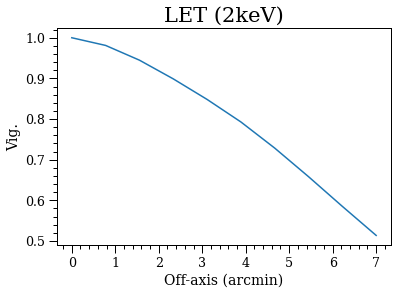

In [30]:
plt.plot(np.linspace(0.,7,10), vig_let)
plt.xlabel('Off-axis (arcmin)')
plt.ylabel('Vig.')
plt.title('LET (2keV)')